Here we use BERT (or rather the smaller DistillBert) pre-trained model to make our embedding vectors. We don't include
any additional training on our corpus due to time constraints. 

BERT embeddings will depend on the context a word is seen in - eg even words with only one meaning can have different 
embeddings depending on the surounding context. We have standard length input vectors, using padding and masking to 
ensure this does not create issues with the model. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings

from nltk.tokenize import sent_tokenize
import gensim.parsing.preprocessing as gen_preproc

import spacy
nlp = spacy.load('en_core_web_sm')

warnings.filterwarnings('ignore')

# Data Import 
The same stuff I've done in all the file / models.

In [2]:
df = pd.read_csv( 'parsed_train.txt', sep='\t', header=None,
                   names=['label', 'text'] )
df['label'] = df['label'].apply(lambda x: int( x.replace("__label__", "") ) - 1)

basicPreproc = [lambda x: x.lower(), gen_preproc.strip_tags, \
    gen_preproc.strip_punctuation, gen_preproc.strip_non_alphanum, \
    gen_preproc.strip_multiple_whitespaces] #, gen_preproc.strip_short, gen_preproc.remove_stopwords

df['basicProc'] = df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
df['stemmed'] = df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
df['lemmatized'] = df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )
df.head()

,label,text,basicProc,stemmed,lemmatized
0,3,The Rock is destined to be the 21st Century 's...,the rock is destined to be the 21st century s ...,the rock is destin to be the 21st centuri s ne...,the rock be destine to be the 21st century s n...
1,4,The gorgeously elaborate continuation of `` Th...,the gorgeously elaborate continuation of the l...,the gorgeous elabor continu of the lord of the...,the gorgeously elaborate continuation of the l...
2,3,Singer/composer Bryan Adams contributes a slew...,singer composer bryan adams contributes a slew...,singer compos bryan adam contribut a slew of s...,singer composer bryan adams contribute a slew ...
3,2,You 'd think by now America would have had eno...,you d think by now america would have had enou...,you d think by now america would have had enou...,-PRON- d think by now america would have have ...
4,3,Yet the act is still charming here .,yet the act is still charming here,yet the act is still charm here,yet the act be still charm here


### Test Loading

In [3]:
test_df = pd.read_csv( 'parsed_test.txt', sep='\t', header=None,
                   names=['label', 'text'] )
test_df['label'] = test_df['label'].apply(lambda x: int( x.replace("__label__", "") ) - 1)
test_df['basicProc'] = test_df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
test_df['stemmed'] = test_df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
test_df['lemmatized'] = test_df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )
test_df.head()

,label,text,basicProc,stemmed,lemmatized
0,2,Effective but too-tepid biopic,effective but too tepid biopic,effect but too tepid biopic,effective but too tepid biopic
1,3,If you sometimes like to go to the movies to h...,if you sometimes like to go to the movies to h...,if you sometim like to go to the movi to have ...,if -PRON- sometimes like to go to the movie to...
2,4,"Emerges as something rare , an issue movie tha...",emerges as something rare an issue movie that ...,emerg as someth rare an issu movi that s so ho...,emerge as something rare an issue movie that s...
3,2,The film provides some great insight into the ...,the film provides some great insight into the ...,the film provid some great insight into the ne...,the film provide some great insight into the n...
4,4,Offers that rare combination of entertainment ...,offers that rare combination of entertainment ...,offer that rare combin of entertain and educ,offer that rare combination of entertainment a...


In [4]:
# Load Bert
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = \
    ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased'

In [5]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

### Prep BERT Input Format
Note that we are using BERT's pretrained tokenizer, but Not refining it further on our own corpus vocabulary or context. This is definitely an area of potential improvement, BERT apparently only needs a minimal number of samples to learn from our data. We cannot even gaurentee that the pre-trained model has seen all of our vocabulary for tokenization.

In [6]:
tokenized = df['lemmatized'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized[0]

[101,
 1996,
 2600,
 2022,
 4078,
 10196,
 2000,
 2022,
 1996,
 7398,
 2301,
 1055,
 2047,
 16608,
 1998,
 2008,
 1011,
 4013,
 2078,
 1011,
 1055,
 2175,
 2000,
 2191,
 1037,
 17624,
 2130,
 2307,
 2084,
 7779,
 29058,
 8625,
 13327,
 3744,
 18856,
 19513,
 3158,
 5477,
 4168,
 2030,
 7112,
 16562,
 2140,
 102]

In [7]:
#Padding where everything is padded to the max length. Could use other functions for padding as well.
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

(8544, 71)

In [8]:
padded[0]

array([  101,  1996,  2600,  2022,  4078, 10196,  2000,  2022,  1996,
        7398,  2301,  1055,  2047, 16608,  1998,  2008,  1011,  4013,
        2078,  1011,  1055,  2175,  2000,  2191,  1037, 17624,  2130,
        2307,  2084,  7779, 29058,  8625, 13327,  3744, 18856, 19513,
        3158,  5477,  4168,  2030,  7112, 16562,  2140,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0])

Masked features tell BERT to Ignore the padding bits. This is important b.c. it means we're not diluting our information when padding, and that having long padding doesn't matter. Note that our max length is only the max length for the training dataset, a sample in the test dataset could be longer (forshadow).

In [9]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(8544, 71)

In [10]:
attention_mask[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

In [11]:
input_ids = torch.tensor(padded)
input_ids = input_ids.to(input_ids.device).long() 
attention_mask = torch.tensor(attention_mask)
attention_mask = attention_mask.to(attention_mask.device).long()

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

# Not Enough RAM hahaha

Fun fact: The previous command does not always fail due to out of RAM errors. I have ~32 GB ram. That used only 7.5 gb, but other processes may be taking up RAM as well. It does not always fail on my own PC, and will presumably depend on the PC used to run this notebook. Anyways...

Ok... lets cut our data down into smaller chunks so that each is processed seperately and we don't need as much RAM. 180 Million Parameters or so is still huge, even if I'm only trying to run 8k sentances through it. This is why Cloud systems are very helpful with modern Huge Models (and also why newer models are not necessarily the best solution for every use case). Its very interesting to look at efficency in algorithms, what performs the best with minimal training and computer requirements? Obviously there's a difference between something that only needs to be refined on smaller datasets and trained from scratch as well. There's lot of interesting things to look into there (like how modern cutting edge models deal with so much data and its quality and scaling!) but so little time!

Note that numpy array split will keep the indexing the same, so don't needa zip & unzip stuff.

In [24]:
7454195712 / 1e9

7.454195712

In [12]:
paddedChunks = np.array_split( padded, 5 )
attentionChunks = np.array_split( attention_mask, 5 )

In [13]:
paddedChunks[0].shape

(1709, 71)

In [14]:
def get_hidden_states(paddedChunk, attentionChunk):
    input_ids = torch.tensor(paddedChunk)
    input_ids = input_ids.to(input_ids.device).long() 
    attention_mask = torch.tensor(attentionChunk)
    attention_mask = attention_mask.to(attention_mask.device).long()

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
        
    return last_hidden_states


In [15]:
last_hidden_states_0 = get_hidden_states(paddedChunks[0], attentionChunks[0])
features_0 = last_hidden_states_0[0][:,0,:].numpy()

In [16]:
last_hidden_states_1 = get_hidden_states(paddedChunks[1], attentionChunks[1])
features_1 = last_hidden_states_1[0][:,0,:].numpy()

In [17]:
last_hidden_states_2 = get_hidden_states(paddedChunks[2], attentionChunks[2])
features_2 = last_hidden_states_2[0][:,0,:].numpy()

In [18]:
last_hidden_states_3 = get_hidden_states(paddedChunks[3], attentionChunks[3])
features_3 = last_hidden_states_3[0][:,0,:].numpy()

In [19]:
last_hidden_states_4 = get_hidden_states(paddedChunks[4], attentionChunks[4])
features_4 = last_hidden_states_4[0][:,0,:].numpy()

In [20]:
train_Y = np.array_split( np.array( list( df['label'] ) ), 5 )
train_Y_0 = train_Y[0]
train_Y_1 = train_Y[1]
train_Y_2 = train_Y[2]
train_Y_3 = train_Y[3]
train_Y_4 = train_Y[4]

In [21]:
lr_clf = LogisticRegression()
lr_clf.fit(features_0, train_Y_0)
lr_clf.fit(features_1, train_Y_1)
lr_clf.fit(features_2, train_Y_2)
lr_clf.fit(features_3, train_Y_3)
lr_clf.fit(features_4, train_Y_4)

LogisticRegression()

In [28]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False)
xgb_model.fit(features_0, train_Y_0)
xgb_model.fit(features_1, train_Y_1)
xgb_model.fit(features_2, train_Y_2)
xgb_model.fit(features_3, train_Y_3)
xgb_model.fit(features_4, train_Y_4)

[22:17:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:18:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:18:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:19:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

## Running with Test

In [22]:
test_tokenized = test_df['lemmatized'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
test_padded = np.array( [i + [0]*(max_len-len(i)) for i in test_tokenized.values] )

#AHHHH, The longest in Test Padded is Longer than in the Training set! 
#This caused test_padded to be an array of lists instead of 2d array
lens = [len(i) for i in test_padded]
print(all([i == 71 for i in lens]))
for i, length in enumerate(lens):
    if length != 71:
        print(i, length)
        print()
        print(test_padded[i])

#Cut off to len 71 only, as that was our original max length.
test_padded = np.array( [np.array( i[:max_len] ) for i in test_padded] )

test_attention_mask = np.where(test_padded != 0, 1, 0)
print( np.array(test_padded).shape )
print( np.array(test_attention_mask).shape )


False
159 76

[101, 1996, 2143, 2022, 11633, 2000, 2054, 2028, 3653, 23545, 2022, 1996, 2338, 1055, 5519, 18458, 2008, 1011, 4013, 2078, 1011, 2468, 2040, 1011, 4013, 2078, 1011, 2022, 2006, 1996, 2067, 1997, 1011, 4013, 2078, 1011, 6687, 2021, 1011, 4013, 2078, 1011, 2031, 2053, 2801, 2040, 1011, 4013, 2078, 1011, 2022, 2012, 1011, 4013, 2078, 1011, 2287, 1998, 2008, 2051, 2022, 1037, 25085, 1998, 9062, 19502, 2053, 3043, 2129, 2214, 1011, 4013, 2078, 1011, 2022, 102]
(2210, 71)
(2210, 71)


In [23]:
test_input_ids = torch.tensor(test_padded)
test_input_ids = test_input_ids.to(test_input_ids.device).long() 
test_attention_mask = torch.tensor(test_attention_mask)
test_attention_mask = test_attention_mask.to(test_attention_mask.device).long()

with torch.no_grad():
    test_hidden_states = model(test_input_ids, attention_mask=test_attention_mask)

In [24]:
test_features = test_hidden_states[0][:,0,:].numpy()
test_predict_Y = lr_clf.predict(test_features)
test_predict_Y

array([3, 2, 1, ..., 1, 1, 0])

In [25]:
true_Y = test_df['label']
true_Y

0       2
1       3
2       4
3       2
4       4
       ..
2205    3
2206    4
2207    4
2208    3
2209    0
Name: label, Length: 2210, dtype: int64

### Logisitc Regression Unbalaned Classes

0.3438914027149321


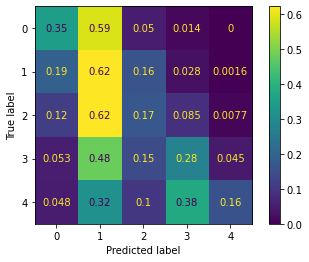

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
print( accuracy_score(true_Y, test_predict_Y) )
MulticlassCM = confusion_matrix( true_Y, test_predict_Y, normalize='true' )
MultiClassDisp = ConfusionMatrixDisplay( MulticlassCM )
MultiClassDisp.plot()

### XGBoost Unbalaned Classes

0.31040723981900453


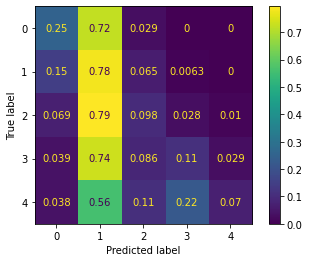

In [29]:
xgb_predict_Y = xgb_model.predict(test_features)
print( accuracy_score(true_Y, xgb_predict_Y) )

xgbCM = confusion_matrix( true_Y, xgb_predict_Y, normalize='true' )
xgbDisp = ConfusionMatrixDisplay( xgbCM )
xgbDisp.plot()

## Lets try with Balanced Data? 
We saw in our unbalanced dataset we were Wildly overfitting to class 1. Interestly, we did not significantly overfit to class 3 as well, which was our other label with a signficiantly higher number of samples. Of course we'd normally fix these issues by having hyperparameters like early stopping enabled, and use a validation split (train, test, validation) to identify good parameters to stop at; but since those are outside the scope of the project they were not included. 

In [30]:
g = df.groupby('label')
g = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
g.head()

label                                               text  \
label                                                               
0     0      0  A low-budget affair , Tadpole was shot on digi...   
      1      0  ( Sam 's ) self-flagellation is more depressin...   
      2      0  An incoherent jumble of a film that 's rarely ...   
      3      0  If I could have looked into my future and saw ...   
      4      0  Movies like High Crimes flog the dead horse of...   

                                                 basicProc  \
label                                                        
0     0  a low budget affair tadpole was shot on digita...   
      1  sam s self flagellation is more depressing tha...   
      2  an incoherent jumble of a film that s rarely a...   
      3  if i could have looked into my future and saw ...   
      4  movies like high crimes flog the dead horse of...   

                                                   stemmed  \
label                                                        
0     0  a low budget affair tadpol wa shot on digit vi...   
      1   sam s self flagel is more depress than entertain   
      2  an incoher jumbl of a film that s rare as ente...   
      3  if i could have look into my futur and saw how...   
      4  movi like high crime flog the dead hors of sur...   

                                                lemmatized  
label                                                       
0     0  a low budget affair tadpole be shoot on digita...  
      1  sam s self flagellation be more depressing tha...  
      2  an incoherent jumble of a film that s rarely a...  
      3  if i could have look into -PRON- future and se...  
      4  movie like high crime flog the dead horse of s...

In [31]:
tokenized_bal = g['lemmatized'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [32]:
padded_bal = np.array([i + [0]*(max_len-len(i)) for i in tokenized_bal.values])

In [33]:
attention_mask_bal = np.where(padded_bal != 0, 1, 0)

In [34]:
input_ids_bal = torch.tensor(padded_bal)
input_ids_bal = input_ids_bal.to(input_ids_bal.device).long() 
attention_mask_bal = torch.tensor(attention_mask_bal)
attention_mask_bal = attention_mask_bal.to(attention_mask_bal.device).long()

with torch.no_grad():
    last_hidden_states_bal = model(input_ids_bal, attention_mask=attention_mask_bal)

In [66]:
features_bal = last_hidden_states_bal[0][:,0,:].numpy()
train_Y_bal = np.array( list( g['label'] ) )

In [67]:
xgb_model_bal = xgb.XGBClassifier(use_label_encoder=False)
xgb_model_bal.fit(features_bal, train_Y_bal)

[14:13:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

0.38868778280542987


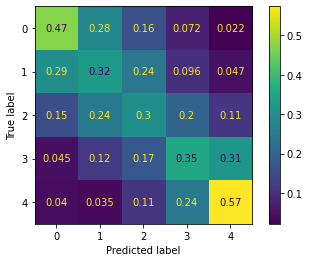

In [68]:
xgb_predict_Y_bal = xgb_model_bal.predict(test_features)
print( accuracy_score(true_Y, xgb_predict_Y_bal) )

xgbBalCM = confusion_matrix( true_Y, xgb_predict_Y_bal, normalize='true' )
xgbBalDisp = ConfusionMatrixDisplay( xgbBalCM )
xgbBalDisp.plot()

Significantly better. We see alot less bias towards a single class. We have a somewhat nice diagnol, though there is issues with identifying the precisely correct class we are at least not predicting randomly or the opposite classes. Interesting that it seems more easy to predict a label the more extreme that label is, and that the model seems to prefer predicting more extreme labels than less extreme ones (eg if the true label is 1, it's more likely to predict 0 than 2, or if true=3, more likely to predict 4 than 2).